Note that I write this notebook by learning topics and source codes from various resources, but the main book that I have read is "Python for Machine Learning" by S. Raschka and V. Mirjalili, which is my favorite. Therefore, most of the codes here will have the same structure as their book. I also would like to thank both authors for writing this easy-understanding book, which I think is the good one for beginners.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn import datasets
iris = datasets.load_iris()

# The Plot Region Function

This function plots observations in the two-dimensional axes, labels an appropriate class to each observation, and highlights the area that each class covers.

In [2]:
from matplotlib.colors import ListedColormap

def plot_region(x, y, classifier, test = None, resolution = 0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    z = z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, z, alpha = 0.3, cmap = cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x = x[y == cl, 0], y = x[y == cl, 1],
                    alpha = 0.8, c = colors[idx],
                    marker = markers[idx], label = cl,
                    edgecolors = 'black')
    if test:
        # Plot all samples
        x_test, y_test = x[test, :], y[test]
        plt.scatter(x_test[:, 0], x_test[:, 1], c = '',
                    edgecolors = 'black', alpha = 1.0,
                    linewidths=1, marker='o', s = 100,
                    label = 'Test Set')

# Perceptron

In [3]:
# Using the iris dataset from above
x = iris.data[:, [2,3]]
y = iris.target

print('Class Labels: ', np.unique(y))

Class Labels:  [0 1 2]


In [4]:
# Split the data, using the stratify sampling method
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1, stratify = y)

# Check the number of observations in each label of y
print('No. of observations: ', np.bincount(y))
print('No. in train', np.bincount(y_train))
print('No. in test', np.bincount(y_test))

No. of observations:  [50 50 50]
No. in train [35 35 35]
No. in test [15 15 15]


## Scaling

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
sc = StandardScaler()
sc.fit(x_train)
x_train_std = sc.transform(x_train)
x_test_std = sc.transform(x_test)

## Perceptron Step 

In [7]:
from sklearn.linear_model import Perceptron

In [8]:
pt = Perceptron(eta0 = 0.1, random_state = 1)
pt.fit(x_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=0.1,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=1, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [9]:
# Accuracy calculation
from sklearn.metrics import accuracy_score

In [10]:
y_pred = pt.predict(x_test_std)
print('Accuracy = %.2f' % accuracy_score(y_pred, y_test))

Accuracy = 0.98


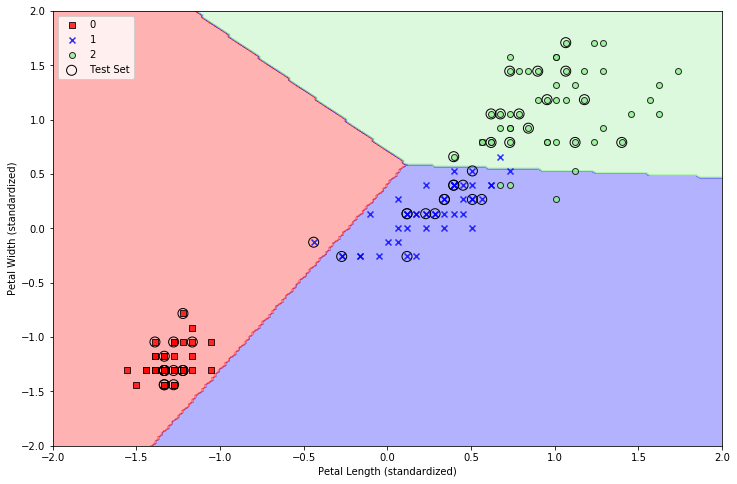

In [11]:
# Plot Region
x_comb = np.vstack((x_train_std, x_test_std))
y_comb = np.hstack((y_train, y_test))
plt.figure(figsize = (12,8))
plot_region(x = x_comb, y = y_comb, classifier=pt, test = range(105,150))
plt.xlabel('Petal Length (standardized)')
plt.ylabel('Petal Width (standardized)')
plt.xlim((-2,2))
plt.ylim((-2,2))
plt.legend(loc = 'upper left')
plt.show()

As you can see from the graph, the algorithm does not work well with the data. That is because the perceptron algorithm never converges on datasets that are not perfectly linearly separable, that's why the use of the perceptron is typically not recommended in practice.

# Logistic Regression

## Sigmoid Activation Function

In [12]:
def sigmoid(z): return 1.0 / (1.0 + np.exp(-z))

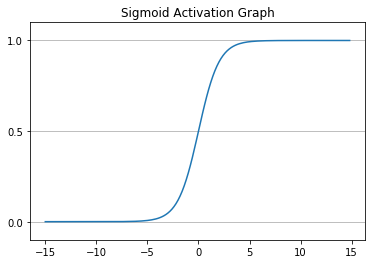

In [13]:
# Test it
z = np.arange(-15, 15, 0.2)
sig_z = sigmoid(z)
plt.plot(z, sig_z)
plt.ylim(-0.1, 1.1)
plt.yticks([0, 0.5, 1.0])
plt.gca().yaxis.grid(True)
plt.title('Sigmoid Activation Graph')
plt.show()

## The Logistic Regression Class

In [14]:
class LogisticRegression(object):
    """
    Logistic Regression using Gradient Descent
    
    Parameters
    --------------
    lr (float): Learning Rate [0.0, 1.0]
    n_iter (int): Number of Iterations
    random_state(int): Random Number Generator
    
    Attributes
    --------------
    w_ (1d-array): Weight Vector
    cost_ (list): Sum-of-Squares cost function value in each epoch
    """
    
    def __init__(self, lr = 0.05, n_iter = 100, random_state = 1):
        self.lr = lr
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, x, y):
        """
        Fit training data
        
        Parameters
        ----------
        x (array-like), shape = [n_samples, n_features]: Training Matrix
        y (array_like), shape = [n_samples]: Target Value Vector
        
        Returns
        ---------
        self: object
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc = 0.0, scale = 0.01, size = 1 + x.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            net_input = self.net_input(x)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.lr * x.T.dot(errors)
            self.w_[0] += self.lr * errors.sum()
            
            cost = -y.dot(np.log(output)) - ((1-y).dot(np.log(1 - output))) 
            self.cost_.append(cost)
        return self
    
    def net_input(self, x):
        return np.dot(x, self.w_[1:]) + self.w_[0]
    
    def activation(self, z):
        "Logistic sigmoid activation"
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def predict(self, x):
        return np.where(self.net_input(x) >= 0.0, 1, 0)

## Try implementing it with the Iris dataset

Note that in this case I will implement the logistic regression in only two classes.

In [15]:
# Only two features will be used as the independent variables
# Because I will visualize it later
x = iris.data[:, [2,3]]
y = iris.target

x = x[(y == 0)|(y == 1)]
y = y[(y == 0)|(y == 1)]

In [16]:
# Train-test split
from sklearn.model_selection import train_test_split

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, random_state = 1, test_size = 0.3)

In [18]:
logreg = LogisticRegression(lr = 0.05, n_iter = 1000, random_state = 1)
logreg.fit(x_train, y_train)

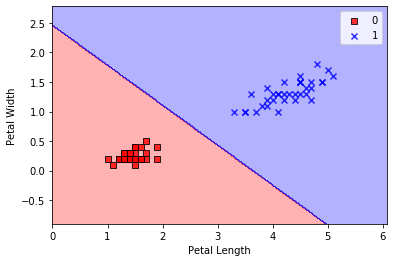

In [19]:
plot_region(x = x_train, y = y_train, classifier=logreg)
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.legend(loc = 'best')
plt.show()

## Logistic Regression in Scikit-Learn 

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
x = iris.data[:, [2,3]]
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1, stratify = y)

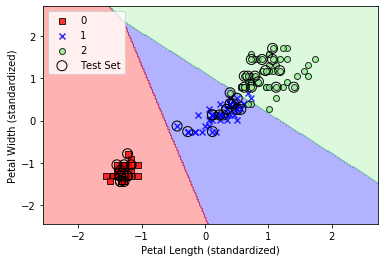

In [22]:
lr = LogisticRegression(C = 100.0, random_state=1)
lr.fit(x_train_std, y_train)
plot_region(x_comb, y_comb, classifier=lr, test = range(105,150))
plt.xlabel('Petal Length (standardized)')
plt.ylabel('Petal Width (standardized)')
plt.legend(loc = 'upper left')
plt.show()

# Logistic Regression with Regularization

The parameter C in the LogisticRegression in scikit-learn is the positive float which is the inverse of the strength of the regularization, smaller values indicate stronger regularization.

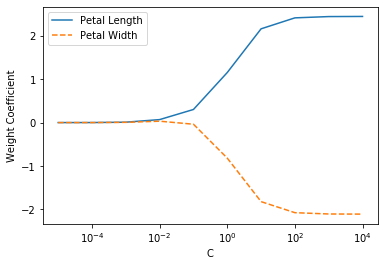

In [27]:
# L2-regularization
weights, params = [], []
for c in np.arange(-5,5):
    lr = LogisticRegression(C = 10.**c, random_state=1)
    lr.fit(x_train_std, y_train)
    weights.append(lr.coef_[1]) # Use one class, we can also do all classes
    params.append(10.**c)
weights = np.array(weights)
plt.plot(params, weights[:, 0], label = 'Petal Length')
plt.plot(params, weights[:, 1], linestyle = '--', label = 'Petal Width')
plt.ylabel('Weight Coefficient')
plt.xlabel('C')
plt.legend(loc = 'upper left')
plt.xscale('log')
plt.show()

The weight coefficients shrink if we increase the regularization strength.

# Support Vector Machines 

In [28]:
from sklearn.svm import SVC

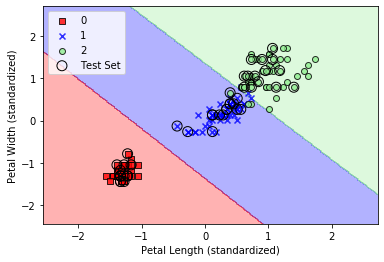

In [31]:
svm = SVC(kernel = 'linear', C = 1.0, random_state=1)
svm.fit(x_train_std, y_train)
plot_region(x_comb, y_comb, classifier=svm, test = range(105,150))
plt.xlabel('Petal Length (standardized)')
plt.ylabel('Petal Width (standardized)')
plt.legend(loc = 'upper left')
plt.show()

# Stochastic Gradient Descent

In [32]:
from sklearn.linear_model import SGDClassifier

In [33]:
sgd_p = SGDClassifier(loss = 'perceptron') # Perceptron
sgd_l = SGDClassifier(loss = 'log')        # Logistic Regression
sgd_h = SGDClassifier(loss = 'hinge')      # Support Vector Machine

# SVM Kernel Methods 

For non-linearly separable data, the previous SVM which implements a linear kernel may not fit the data well. Therefore, the non-linear kernel is introduced to deal with this issue.

For this part, I will generate a new non-linear dataset.

In [34]:
# Generate new dataset
import matplotlib.pyplot as plt

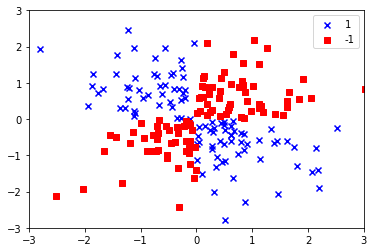

In [35]:
np.random.seed(1)
x = np.random.randn(200,2)
y = np.logical_xor(x[:,0] > 0, x[:,1] > 0)
y = np.where(y, 1, -1)

plt.scatter(x[y == 1, 0], x[y == 1, 1], c = 'b', marker = 'x', label = '1')
plt.scatter(x[y == -1, 0], x[y == -1, 1], c = 'r', marker = 's', label = '-1')
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.legend(loc = 'best')
plt.show()

In [36]:
from sklearn.svm import SVC

In [37]:
svm = SVC(kernel = 'rbf', random_state=1, gamma = 0.5, C = 10.0) 
#select a non-linear kernel to deal with non-linear-separable data
svm.fit(x,y)

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.5, kernel='rbf',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)

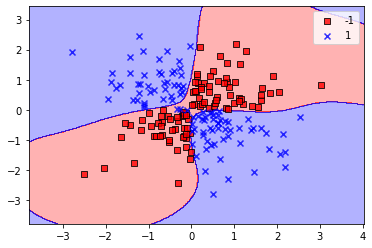

In [39]:
plot_region(x, y, classifier = svm)
plt.legend(loc = 'best')
plt.show()

# Decision Tree Classifier

In [40]:
from sklearn.tree import DecisionTreeClassifier

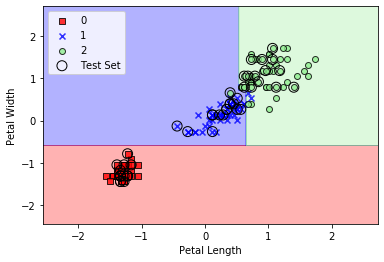

In [43]:
tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 4, random_state=1)
tree.fit(x_train_std, y_train)
plot_region(x_comb, y_comb, classifier=tree, test = range(105,150))
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.legend(loc = 'upper left')
plt.show()

# Random Forest Classifier

In [44]:
from sklearn.ensemble import RandomForestClassifier

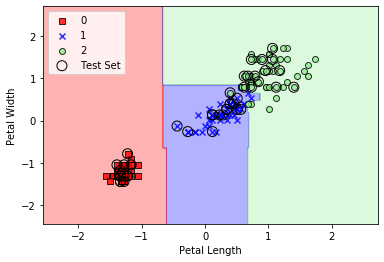

In [45]:
rf = RandomForestClassifier(criterion='gini', n_estimators=25,
                            random_state=1, n_jobs=2)
rf.fit(x_train_std, y_train)
plot_region(x_comb, y_comb, classifier=rf, test = range(105,150))
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.legend(loc = 'upper left')
plt.show()

# K-Nearest Neighbors

In [46]:
from sklearn.neighbors import KNeighborsClassifier

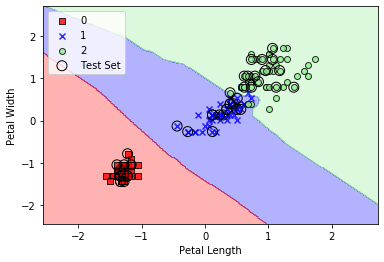

In [47]:
knn = KNeighborsClassifier(n_neighbors=5, p = 2, metric='minkowski')
knn.fit(x_train_std, y_train)
plot_region(x_comb, y_comb, classifier=knn, test = range(105,150))
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.legend(loc = 'upper left')
plt.show()